In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install h5py==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: Could not build wheels for h5py, which is required to install pyproject.toml-based projects


In [ ]:
import tensorflow as tf
print("tensorflow version :{}".format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tensorflow version :2.15.0
Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14712445874153432229
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14602556403609857041
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#### physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

In [ ]:

#from keras.layers import Conv1D, Dense, Dropout, GlobalMaxPool1D, MaxPool1D
from keras.layers import Conv2D, Dense, Dropout, GlobalMaxPooling2D, Reshape
from keras.layers import TimeDistributed, LSTM, Bidirectional, Input, concatenate,RepeatVector
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1,l2
from statsmodels.tsa.stattools import adfuller


In [ ]:
data_path = "/content/drive/MyDrive/CAV/data/Bias attack/0_1_dur_10/"

In [ ]:
sensor1_data = pd.read_csv(data_path + "Sensor1_values_bias_0_1_dur_10_dep.csv", index_col= 'Unnamed: 0')
sensor1_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
len(sensor1_data)

29800

In [ ]:
sensor1_label = pd.read_csv(data_path + "Ground_truth_bias_0_1_dur_10_sensor1_dep.csv", names=['Class'])
sensor1_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
len(sensor1_label)

29800

In [ ]:
sensor2_data = pd.read_csv(data_path + "Sensor2_values_bias_0_1_dur_10_dep.csv", index_col = "Unnamed: 0")
sensor2_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor2_label = pd.read_csv(data_path + "Ground_truth_bias_0_1_dur_10_sensor2_dep.csv",names=['Class'])
sensor2_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor3_data = pd.read_csv(data_path + "Sensor3_values_bias_0_1_dur_10_dep.csv", index_col = "Unnamed: 0")
sensor3_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor3_label = pd.read_csv(data_path + "Ground_truth_bias_0_1_dur_10_sensor3_dep.csv", names=['Class'])
sensor3_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_data['minus_speed'] = sensor1_data['InVehicle_Longitudinal_Speed']-sensor1_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor1_data['minus_acc'] = sensor1_data['InVehicle_Longitudinal_Accel']-sensor1_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor1_data['minus_Gps'] = sensor1_data['GPS_Speed']-sensor1_data['GPS_Speed'].shift(1)


In [ ]:
sensor2_data['minus_speed'] = sensor2_data['InVehicle_Longitudinal_Speed']-sensor2_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor2_data['minus_acc'] = sensor2_data['InVehicle_Longitudinal_Accel']-sensor2_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor2_data['minus_Gps'] = sensor2_data['GPS_Speed']-sensor2_data['GPS_Speed'].shift(1)


In [ ]:
sensor3_data['minus_speed'] = sensor3_data['InVehicle_Longitudinal_Speed']-sensor3_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor3_data['minus_acc'] = sensor3_data['InVehicle_Longitudinal_Accel']-sensor3_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor3_data['minus_Gps'] = sensor3_data['GPS_Speed']-sensor3_data['GPS_Speed'].shift(1)


In [ ]:
sensor1_data.dropna(inplace= True)
sensor2_data.dropna(inplace= True)
sensor3_data.dropna(inplace= True)


array([<Axes: >, <Axes: >], dtype=object)

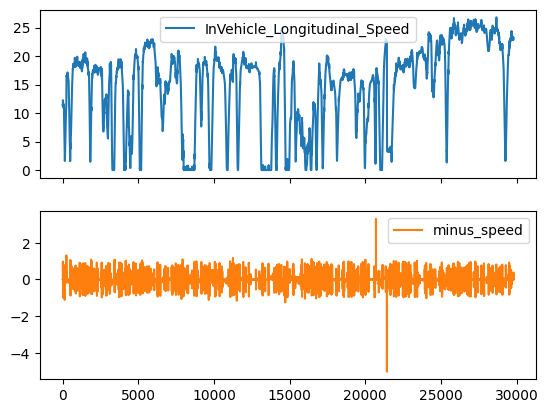

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

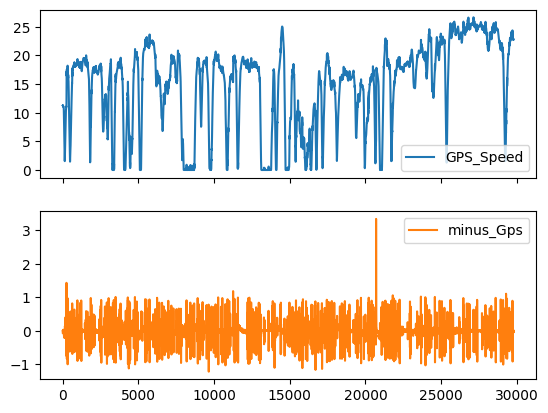

In [ ]:
sensor1_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

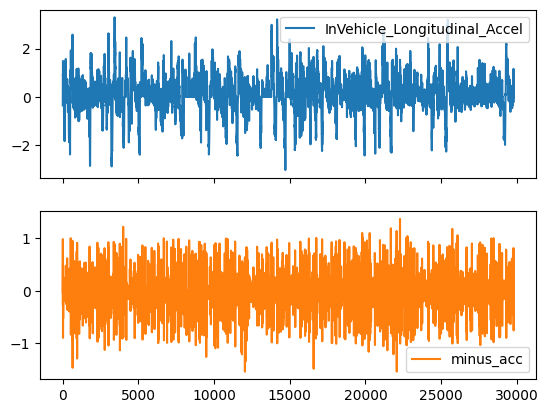

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor1_data['InVehicle_Longitudinal_Speed'])
stationary_gps = adfuller(sensor1_data['GPS_Speed'])
stationary_acc = adfuller(sensor1_data['InVehicle_Longitudinal_Accel'])
print("stationary_speed : {}\n stationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 8.921112879582426e-12
 stationary_gps :1.254040130531171e-11
stationary_acc :1.2701482412351809e-28



In [ ]:
stationary_speed = adfuller(sensor1_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor1_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor1_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 4.776412687072011e-29
stationary_gps :3.806371260531193e-29
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

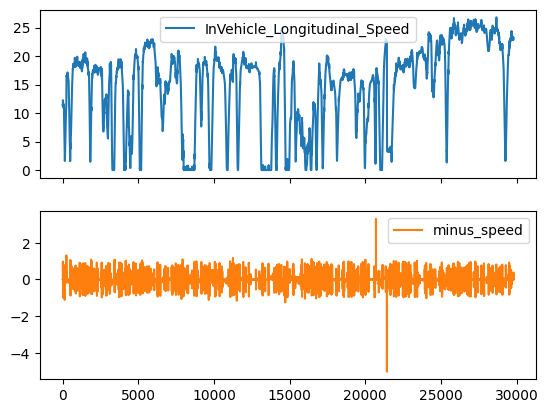

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

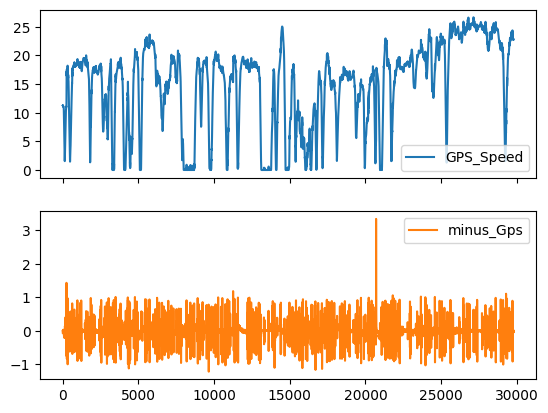

In [ ]:
sensor2_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

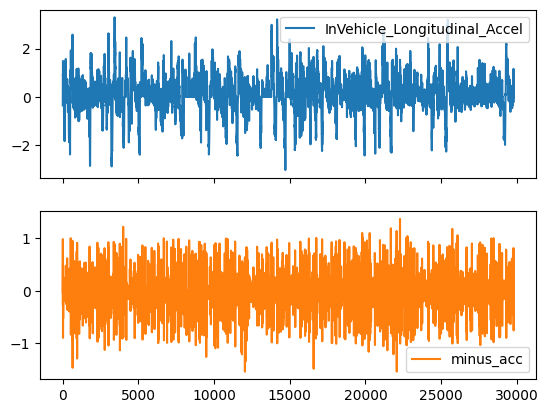

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor2_data['InVehicle_Longitudinal_Speed'])
stationary_gps = adfuller(sensor2_data['GPS_Speed'])
stationary_acc = adfuller(sensor2_data['InVehicle_Longitudinal_Accel'])
print("stationary_speed : {}\n stationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 8.921112879582426e-12
 stationary_gps :1.254040130531171e-11
stationary_acc :1.2701482412351809e-28



In [ ]:
stationary_speed = adfuller(sensor2_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor2_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor2_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 4.776412687072011e-29
stationary_gps :3.806371260531193e-29
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

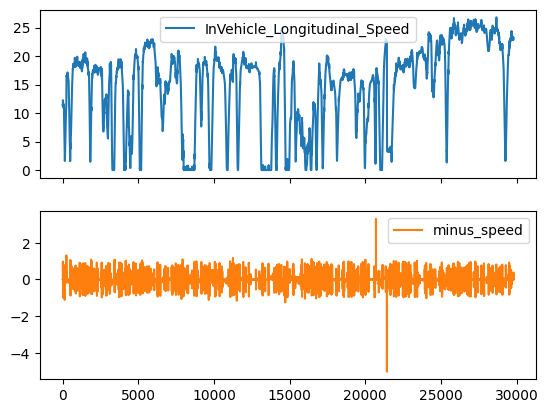

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

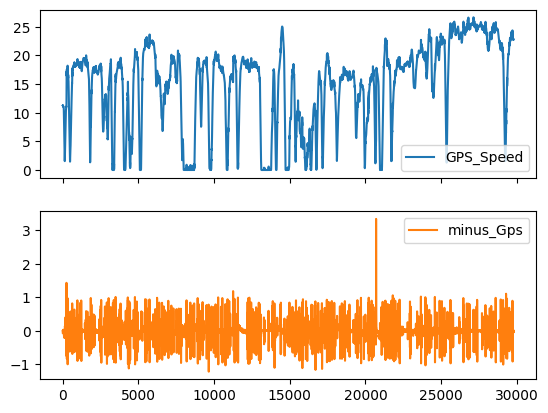

In [ ]:
sensor3_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

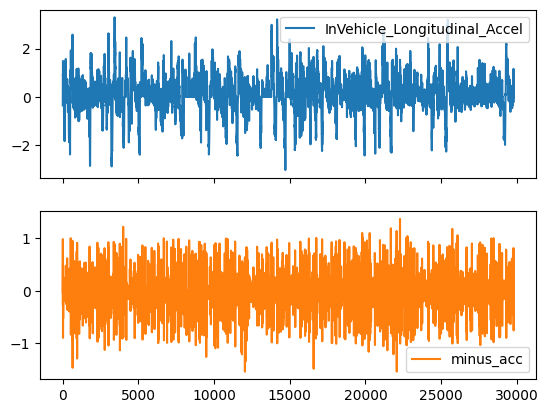

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor3_data['InVehicle_Longitudinal_Speed'])
stationary_gps = adfuller(sensor3_data['GPS_Speed'])
stationary_acc = adfuller(sensor3_data['InVehicle_Longitudinal_Accel'])
print("stationary_speed : {}\n stationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 8.921112879582426e-12
 stationary_gps :1.254040130531171e-11
stationary_acc :1.2701482412351809e-28



In [ ]:
stationary_speed = adfuller(sensor3_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor3_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor3_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 4.776412687072011e-29
stationary_gps :3.806371260531193e-29
stationary_acc :0.0



In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal = scaler.transform(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal[:5]

array([[-0.06209951, -0.39849527, -1.63251225],
       [-0.03412675, -0.05595338,  1.71076563],
       [-0.02904709,  0.10658247,  0.30892064],
       [-0.01656499,  0.05179228,  0.03829601],
       [-0.01131926, -0.11759115, -0.01406305]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal = scaler.transform(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal[:5]

array([[-0.06209951, -0.39849527, -1.63251225],
       [-0.03412675, -0.05595338,  1.71076563],
       [-0.02904709,  0.10658247,  0.30892064],
       [-0.01656499,  0.05179228,  0.03829601],
       [-0.01131926, -0.11759115, -0.01406305]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal = scaler.transform(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal[:5]

array([[-0.06209951, -0.39849527, -1.63251225],
       [-0.03412675, -0.05595338,  1.71076563],
       [-0.02904709,  0.10658247,  0.30892064],
       [-0.01656499,  0.05179228,  0.03829601],
       [-0.01131926, -0.11759115, -0.01406305]])

In [ ]:
window_size = 10

# create windows with overlap
def convertToFrames(X_data,y_data, step):
    X, Y =[], []
    for i in range(len(X_data)-step):
        y_or = 0
        d=i+step
        X.append(X_data[i:d,])
        for y in y_data.iloc[i:d].values:
           y_or = y_or or y

        Y.append(y_or)
    return np.array(X), np.array(Y)

In [ ]:
X_sensor1, y_sensor1 = convertToFrames(sensor1_data_normal, sensor1_label, window_size)
X_sensor1.shape, y_sensor1.shape
# print(X_sensor1[0])
# print(X_sensor1[1])

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor2, y_sensor2 = convertToFrames(sensor2_data_normal, sensor2_label, window_size)
X_sensor2.shape, y_sensor2.shape

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor3, y_sensor3 = convertToFrames(sensor3_data_normal, sensor3_label, window_size)
X_sensor3.shape, y_sensor3.shape

((29789, 10, 3), (29789, 1))

In [ ]:
y_sensors = []
for i in range(len(y_sensor1)):
  y_sensors.append(y_sensor1[i] or y_sensor2[i] or y_sensor3[i])

In [ ]:
y_sensors = to_categorical(y_sensors, num_classes= 2, dtype='float32')
y_sensors.shape

(29789, 2)

In [ ]:
X_sensors = np.concatenate((X_sensor1,X_sensor2,X_sensor3),axis=1)
X_sensors.shape

(29789, 30, 3)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(X_sensors):
    # Split the data based on the indices
    X_train_sensors, X_test_sensors = X_sensors[train_index], X_sensors[test_index]
    y_train_sensors, y_test_sensors = y_sensors[train_index], y_sensors[test_index]


In [ ]:
X_train_sensors.shape, X_test_sensors.shape, y_train_sensors.shape, y_test_sensors.shape

((27081, 30, 3), (2708, 30, 3), (27081, 2), (2708, 2))

In [ ]:

def creatModel():

    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train_sensors.shape[1], X_train_sensors.shape[2], 1)))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=60, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.1))
    #model.add(Conv2D(filters=60, kernel_size=(3, 3), activation='relu', padding='same'))
    #model.add(Dropout(0.1))
    model.add(GlobalMaxPooling2D())
    model.add(RepeatVector(X_train_sensors.shape[1]))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(rate=0.2))
    #model.add(LSTM(128, return_sequences=True))
    #model.add(Dropout(rate=0.2))
    #model.add(LSTM(64, return_sequences=False))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2()))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
import time

class TimeHistory(Callback):

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        logs['epoch_time'] = epoch_time


In [ ]:
# Function to calculate prediction time
def calculate_prediction_time(model, X_data):
    start_time = time.time()
    predictions = model.predict(X_data)
    end_time = time.time()
    prediction_time = end_time - start_time
    return prediction_time, predictions


In [ ]:
model_path = '/content/drive/MyDrive/CAV/data/Bias attack/0_1_dur_10/Models/Models16-1-MultiChannel-KF-OR-2D-CNN-40-60-LSTM-256/'

class Model_save(Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save(model_path + "D-CNN-LSTM-autoEncoder-Bias-0_1_dur_10-CAV-perEpoch_{}.h5".format(sensor))


In [ ]:
def setCallbacks(sensor):

  best_model_path = model_path + 'Best_D-CNN-LSTM-autoEncoder-Bias-0_1_dur_10-CAV_{}.h5'.format(sensor)
  checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

  history_cb = tf.keras.callbacks.CSVLogger(model_path + 'historyLOG_Bias-0_1_dur_10_{}.csv'.format(sensor), separator=",", append=True)

  model_save = Model_save()

  Estop = EarlyStopping(monitor='val_accuracy', patience= 100)

  return model_save, checkpoint, history_cb, Estop

In [ ]:
sensor = "sensors"
time_callback = TimeHistory()
model_sensors = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensors")
history_sensors = model_sensors.fit(X_train_sensors, y_train_sensors,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#


Epoch 1/500
191/191 [==============================] - 10s 15ms/step - loss: 0.3346 - accuracy: 0.8689 - val_loss: 0.2931 - val_accuracy: 0.8782 - epoch_time: 9.4397
Epoch 2/500
  1/191 [..............................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8828

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 2s 13ms/step - loss: 0.2475 - accuracy: 0.9036 - val_loss: 0.2616 - val_accuracy: 0.8955 - epoch_time: 2.1965
Epoch 3/500
191/191 [==============================] - 2s 11ms/step - loss: 0.2220 - accuracy: 0.9132 - val_loss: 0.2729 - val_accuracy: 0.8852 - epoch_time: 2.0253
Epoch 4/500
191/191 [==============================] - 2s 9ms/step - loss: 0.2047 - accuracy: 0.9197 - val_loss: 0.2411 - val_accuracy: 0.9011 - epoch_time: 1.5930
Epoch 5/500
191/191 [==============================] - 2s 9ms/step - loss: 0.1969 - accuracy: 0.9220 - val_loss: 0.2698 - val_accuracy: 0.9000 - epoch_time: 1.6573
Epoch 6/500
191/191 [==============================] - 2s 9ms/step - loss: 0.1890 - accuracy: 0.9259 - val_loss: 0.2437 - val_accuracy: 0.9059 - epoch_time: 1.5809
Epoch 7/500
191/191 [==============================] - 2s 8ms/step - loss: 0.1772 - accuracy: 0.9288 - val_loss: 0.3016 - val_accuracy: 0.8966 - epoch_time: 1.5613
Epoch 8/500
191/191 [=====

In [ ]:
print(model_sensors.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 3, 40)         400       
                                                                 
 dropout (Dropout)           (None, 30, 3, 40)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 3, 60)         21660     
                                                                 
 dropout_1 (Dropout)         (None, 30, 3, 60)         0         
                                                                 
 global_max_pooling2d (Glob  (None, 60)                0         
 alMaxPooling2D)                                                 
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 60)            0         
 r)                                                     

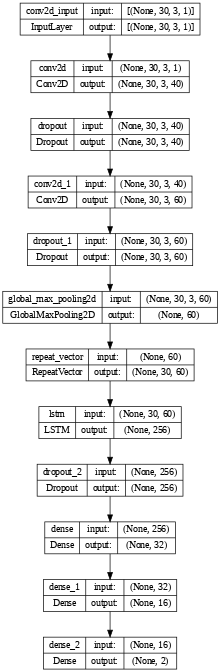

In [ ]:
plot_model(model= model_sensors, show_shapes= True, dpi=50)

In [ ]:
#plot history of model_sensor1
history_sensors = pd.read_csv(model_path +"historyLOG_Bias-0_1_dur_10_sensors.csv", index_col='epoch')
history_sensors.reset_index(drop= True, inplace= True)
history_sensors.head()
print('Average Exe_time for sensors: {} sec.'.format(round(np.mean(history_sensors['epoch_time'].values),3)))


Average Exe_time for sensors: 1.81 sec.


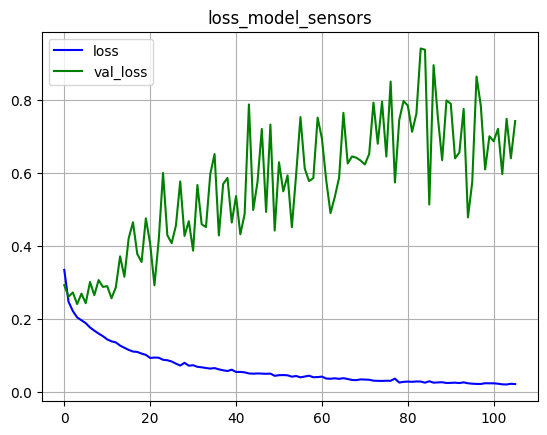

In [ ]:
plt.plot( history_sensors['loss'], 'b',label = 'loss')
plt.plot( history_sensors['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensors')
plt.show()

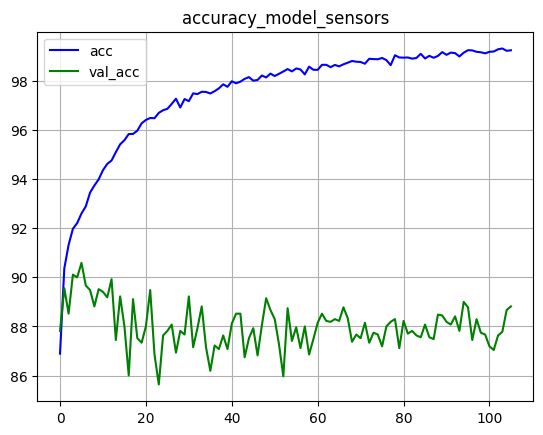

In [ ]:
plt.plot(history_sensors['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensors['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensors')
plt.show()

In [ ]:
model_sensors = load_model(model_path + "D-CNN-LSTM-autoEncoder-Bias-0_1_dur_10-CAV-perEpoch_sensors.h5")

In [ ]:
# Calculate prediction time for sensors
prediction_time_sensors, _ = calculate_prediction_time(model_sensors, X_test_sensors)
print(f'Prediction time for sensors: {prediction_time_sensors} seconds')

85/85 [==============================] - 1s 4ms/step
Prediction time for sensors: 0.9600305557250977 seconds


In [ ]:
#last model_sensor1 evaluation
test_loss, test_acc = model_sensors.evaluate( X_test_sensors, y_test_sensors, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 1s 3ms/step - loss: 0.6604 - accuracy: 0.9199
test accuracy :92.0% 
 test loss :0.66


In [ ]:
y_pred_sensors = model_sensors.predict( X_test_sensors, verbose= 1)


85/85 [==============================] - 0s 3ms/step


In [ ]:
y_pred_sensors = [np.argmax(i) for i in y_pred_sensors]


In [ ]:
y_test_sensors = [np.argmax(i) for i in y_test_sensors]


In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_sensors, y_pred_sensors, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensors, y_pred_sensors, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensors, y_pred_sensors, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensors, y_pred_sensors)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 91.99%

precision score: 91.99%

F1 score: 91.99%

accuracy score: 91.99%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_sensors, y_pred_sensors, average='macro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensors, y_pred_sensors, average='macro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensors, y_pred_sensors, average='macro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensors, y_pred_sensors)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 92.46%

precision score: 91.77%

F1 score: 91.92%

accuracy score: 91.99%



In [ ]:
conf = confusion_matrix(y_test_sensors, y_pred_sensors, labels=[1,0])
conf_df = pd.DataFrame(conf, columns= [1,0], index= [1,0])
conf_df

,1,0
1,1366,170
0,47,1125
